Osnabrück University - A&C: Computational Cognition (Summer Term 2019)

# Exercise Sheet 03: Analysis of behavioural data

## Introduction

This week's sheet should be solved and handed in at 14:00 at **Tuesday, May 7, 2019**. If you need help (and Google and other resources were not enough), feel free to contact your tutors. Please push your results to your Github group folder.

In this exercise sheet we will start to work on a real dataset from an ongoing experiment. In this experiment the participants were asked to freely explore an unknown virtual city, called Seahaven, with an interactive map. After a sufficiently long exploration the participants were tested on three different tasks: 

- the **absolute orientation** of a single house towards the north cardinal direction
- the **relative orientation** between two houses 
- **pointing** from the location of one house to the other

Each task type was performed in two time conditions:

- **3 seconds** for spontaneous decisions
- **infinite** response time for cognitive reasoning

These measurements were repeated up to three times on different days.

We will provide you with more detailed information about this experiment in the tutorial. If you are interested in more than this feel free to have a look at the paper https://www.biorxiv.org/content/10.1101/539080v1.

A small side remark to the dataset: The RTs for the absolute task are exactly the same for both time conditions. This is an error that cannot be corrected on a short notice. Please keep that in mind, when you evaluate your plots.

## Assignment 0: Peer review for sheet 02 [3 pts]

Open an issue in the repository of the groups you have to check. The title of the issue should be your group name (e.g. "Group1). Comment on what was good and what was bad, the aesthetics and ease of reading the plots, what you would have done differently and how many points you would give them for their solutions.

| * |Group 1|Group 2|Group 3|Group 4|Group 5|Group 6|Group 7|Group 8|Group 9|Group 10|Group 11|
| ------- | ----- | ----- | ----- | ----- | ----- | ----- | ----- | ----- | ----- | ------ | ------ |
| check solutions of group: | 11, 9 | 5, 1  | 8, 2  | 2, 7 | 10, 6 | 7, 11 | 6, 5  | 4, 3  | 3, 8  | 1, 4   | 9, 10  |

## Assignment 1: Preprocessing [3 pts]

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from scipy import stats
import xlrd

In [3]:
# use pd.set_option here to display in a nice way
# only display 30 rows
pd.set_option("display.max_rows", 30)
# displays precision for decimal numbers
pd.set_option("display.precision", 3)
pd.set_option('mode.chained_assignment', None)

### a) Preprocessing the data [1 pt]

First of all you should preprocess the data. This is an important step to avoid running into any problems when you start to analyse the data. Since we provide the Seahaven dataset as an excel file make sure to run ```pip install xlrd``` in your activated acc environment beforehand. This allows you to directly read from excel files.

- Import the data of all three tasks (Absolute, Relative, Pointing) into one dataframe. Since we don't need the whole data, load only the columns "ReactionTime", "AngularDiffBin", "Subject", "Task", "Time", "Answer" and "Measurement".
- Clean the dataframe of all NaNs, i.e. remove all rows where at least one element is missing. How many rows have been removed?
- Change the values of the column "Answer". Replace each value "wrong" with 0 and each value "correct" with 1.

In [4]:
# set path of dataset
path = 'Seahaven_dataset.xlsx'

# load all three sheets of the dataset into an ordererd dict of dataframes
seaHaven = pd.read_excel(path, sheet_name=['AbsoluteTask', 'RelativeTask', 'PointingTask'])

# concatenate the 3 respective dataframes into one dataframe
seaHaven = pd.concat([seaHaven['AbsoluteTask'], seaHaven['RelativeTask'], seaHaven['PointingTask']], sort=False, ignore_index=True)

# use relevant columns
seaHaven = seaHaven[['ReactionTime', 'AngularDiffBin', 'Subject', 'Task', 'Time', 'Answer', 'Measurement']] 

# Calculate the number of rows that have been dropped due to NaN-values
len_before = len(seaHaven)
seaHaven = seaHaven.dropna() # drop NaN-values
len_after = len(seaHaven)
print((len_before-len_after),"rows were removed because of NaN-values. There are still", len_after,"rows left.")


# set all values of Answer corresponding to 'wrong' to 0, those to 'correct' to 1
seaHaven.loc[seaHaven['Answer'] == 'wrong', 'Answer'] = 0
seaHaven.loc[seaHaven['Answer'] == 'correct', 'Answer'] = 1

1301 rows were removed because of NaN-values. There are still 20083 rows left.


### b) Checking the distribution of the data [2 pts]

Most of the analysis techniques require normally distributed data. To get an idea on how the data looks like use the **preprocessed data** from 1.a) and plot for each task a violinplot that displays the data distribution of the RTs (note that you also have to distinguish between the two time conditions - 3sec and Infinite).

- For each task (Absolute, Relative, Pointing) and time condition (3sec, Infinite) calculate the mean RT per subject.
- Make a violinplot for each combination of task and time condition (you should end up with 6 violinplots). Make sure that the data distributions are displayed clearly and that the y-axes are uniformly scaled to make your plots comparable. You may split up the single plots for a better overview.
- Hint: Play with the keyword inner.
- Using your plots, what can you say about the distribution of the data? It is normally distributed? How is it skewed?

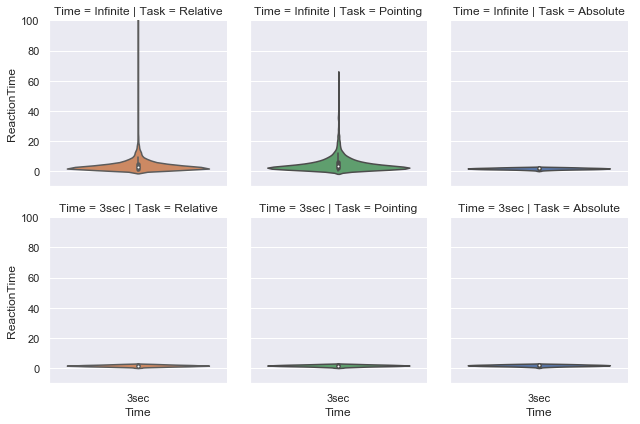

In [5]:
# group by Task and Time and then compute for each group the respective mean of Reaction Time
seaHaven['MeanReactionTime'] = list(range(len(seaHaven.index)))
seaHaven['MeanReactionTime'] = seaHaven.groupby(
    [seaHaven['Task'],seaHaven['Time'], seaHaven['Subject']]).transform('mean')

# order for appearance of plots
ordered_cols = seaHaven.Task.value_counts().index
ordered_rows = seaHaven.Time.value_counts().index

# create #Task x #Time violinplots for Task and Time conditions
grid = sns.FacetGrid(data=seaHaven,col = 'Task', row = 'Time',
                     hue = 'Task', col_order = ordered_cols, row_order = ordered_rows)
grid = grid.map(sns.violinplot, 'Time', 'ReactionTime', order=None)
# set y axis limits
grid.set(ylim=[-10,100])

The ReactionTime for the 3sec condition is not skewed and looks normally distributed.
This also holds for ***Infinite, Absolute***-condition. The data of the ***Infinite, Relative***
and ***Infinite,Pointing*** conditions takes extreme high values on the x-axis, which could be
outliers. It's not possible to plot all graphs in a beatiful manner at the same scales
because of extreme values aka outliers.

You may have noticed that there are (extreme) outliers, that have to be removed from the **preprocessed data**.

- For each task (Absolute, Relative, Pointing) and time condition (3sec, Infinite) look at the RTs and keep only the ones that are within +2 and -2 standard deviation:

$ |(RT_{group1} - mean(RT_{group1}))| \leq (2*std(RT_{group1})) $

$group1$ = e.g. data of absolute task for time condition 3sec

- Make again a violinplot for each combination of task and time condition (you should end up with 6 violinplots). Make sure that the data distributions are displayed clearly and that the y-axes are uniformly scaled to make your plots comparable. You may split up the single plots for a better overview.
- How does the distribution of the data look now? Is it still skewed?

4362 outliers were removed iteratively.


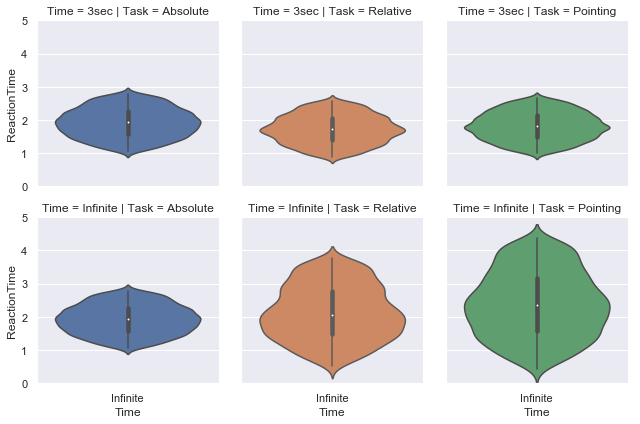

In [6]:
#iteratively remove all outliers 
still_outliers = True
len_before = len(seaHaven)

while(still_outliers == True):
    len_during=len(seaHaven)
    # compute mean and std grouping by Task and Time values 
    mean = seaHaven.groupby([seaHaven['Task'], seaHaven['Time']])['ReactionTime'].transform(np.nanmean)
    std = seaHaven.groupby([seaHaven.Task, seaHaven.Time])['ReactionTime'].transform(np.nanstd)
    # put rows with too large absolute std to NaN
    seaHaven.loc[np.abs(seaHaven['ReactionTime'] - mean) > 2*std, 'ReactionTime'] = np.nan
    # drop rows with NaN values
    seaHaven = seaHaven.dropna()
    #if no outlier was removed anymore: stop
    if(len_during == len(seaHaven)):
        still_outliers = False        

print(len_before-len(seaHaven), "outliers were removed iteratively.")

# order for appearance of plots
ordered_cols = seaHaven.Task.value_counts().index
ordered_rows = seaHaven.Time.value_counts().index

# create #Task x #Time violinplots for Task and Time conditions
grid = sns.FacetGrid(data=seaHaven, col = 'Task', row = 'Time', hue = 'Task',
                     col_order = ordered_cols, row_order = ordered_rows)
grid = grid.map(sns.violinplot, 'Time', 'ReactionTime', order = None)
# sets limitations of y-axis
grid.set(ylim=[0,5])

The data distribution of the 3sec-condition is not skewed. For the infinity task condition the
plots are not completely symmetric: they extend in the direction of larger y-values.
For all 3 taskconditions in the 3sec time condition the distribution is rather equal. This
doesn't hold for the Infnite-Time condition: in ***Pointing,Infinite*** the distribution takes the
highest values, in ***Infinite, Absolute*** the smallest values. ***Infinite, Relative*** is in between the
other two.

**Please make sure that you use the preprocessed data without outliers for the following assignments!**

## Assignment 2: Checking for possible hypotheses [5 pts]

### a) Hypothesis 1 [2 pt]

**Hypothesis 1:** "Given that subjects are limited by time, if they are faster in RT they are also less accurate."

- Use the data of the relative task.
- For each time condition (3sec / Infinite) calculate the mean RT and Accuracy per subject. Rename the column "Answer" to "Accuracy" (the accuracy corresponds to the averaged answer-values).
- Make a scatterplot of the mean RT (x-axis) and the accuracy (y-axis) for the time condition "3sec". 
- Make a second scatterplot and add a simple linear regression line to it. Calculate the slope of the regression line (you are allowed to use scipy). 
- Considering your results, what can you say about the hypothesis?

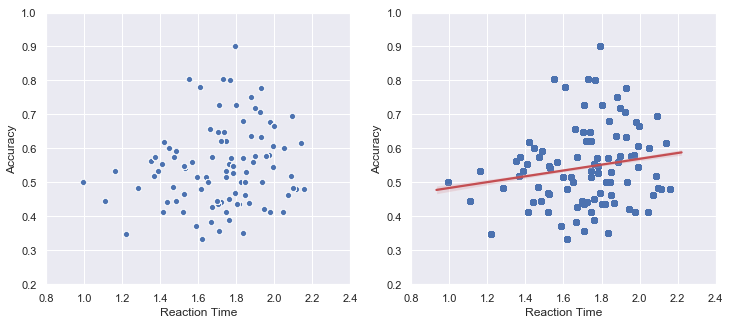

In [17]:
# create df which only takes seahaven time condition = '3sec' into account
dfrelative = seaHaven[seaHaven['Task'] == 'Relative']
# create column for mean RT and Accuracy per subject grouped by Time
dfrelative['AccuracyCondTime'] = list(range(len(dfrelative.index)))
dfrelative['AccuracyCondTime'] = seaHaven.groupby(
    [dfrelative['Subject'], dfrelative['Time']])['Answer'].transform('mean')
dfrelative['RTCondTime'] = list(range(len(dfrelative.index)))
dfrelative['RTCondTime'] = dfrelative.groupby(
    [dfrelative['Subject'], dfrelative['Time']])['ReactionTime'].transform('mean')

# create a figure
fig, axes = plt.subplots(ncols=2)

# first plot with just scatter
axes[0] = sns.scatterplot(
    x="RTCondTime", y="AccuracyCondTime", data=dfrelative[dfrelative['Time'] == '3sec'],ax=axes[0])
# we want to have nice plots so better set the labels right!
axes[0].set(xlabel='Reaction Time', ylabel='Accuracy')

# second plot with additional linear regression line
axes[1] = sns.regplot(x="RTCondTime", y="AccuracyCondTime", data=dfrelative[dfrelative['Time'] == '3sec'], line_kws={'color': 'r'}, ax=axes[1])
# set labels right!
axes[1].set(xlabel='Reaction Time', ylabel='Accuracy')

# set the size of the figure
fig.set_size_inches(12, 5)

# set xlims and ylims of axes
axes[0].set(xlim=[0.8,2.4], ylim=[0.2,1])
axes[1].set(xlim=[0.8,2.4], ylim=[0.2,1])

# calculates slope of the linear regression
slope, intercept, r_value, p_value, std_err = stats.linregress(
    dfrelative['RTCondTime'],dfrelative['AccuracyCondTime'])

It looks like the linear regression is not a really good model in this case: still the linear 
regression can explain some of the data distribution. Considering the slope of ~0.03486,
one can say that there is a weak positive correlation. Therefore the hypothesis that
___"Given that subjects are limited by time if they are faster in RT they are also less accurate"___ can be supported, but also can not explain the whole data distribution.

### b) Hypothesis 2 [1 pt]

**Hypothesis 2:** "Given that subjects have infinite time, they perform better."

- Use the data of all three tasks.
- For each task (Absolute, Relative, Pointing) and time condition (3sec, Infinite) calculate the accuracy per subject. Rename the column "Answer" to "Accuracy" (the accuracy corresponds to the averaged answer-values).
- Make a pointplot of the tasks (x-axis) and the accuracy (y-axis) for both time conditions (3sec / Infinite). The y-axis should start at 0.0 and end at 1.0.
- For better comparison print both conditions in one plot and add a line at accuracy=0.5 to check if the results are above chance.
- Hint: Play with the keyword dodge.
- Considering your plots, what can you say about the hypothesis?

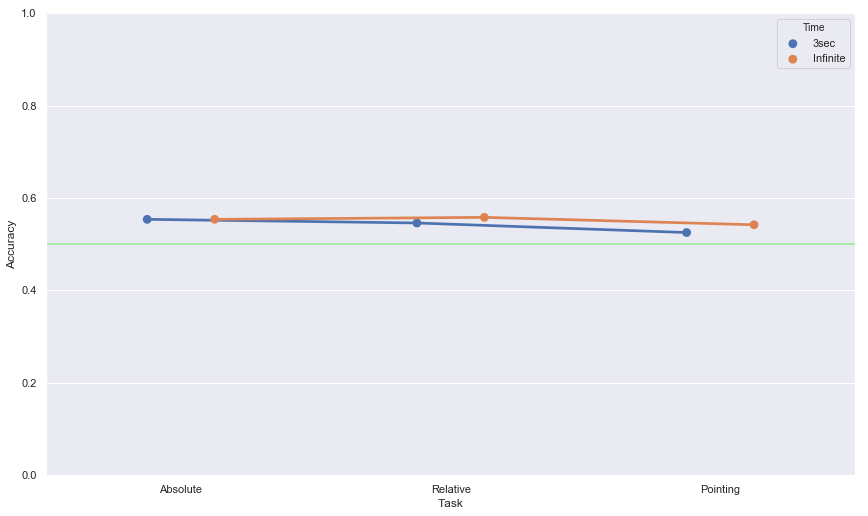

In [20]:
# create figure
fig, ax = plt.subplots(ncols=1)

# create column for mean Accuracy per subject grouped by Time, Subject, and Task
seaHaven['Accuracy'] = list(range(len(seaHaven.index)))
seaHaven['Accuracy'] = seaHaven.groupby(
    [seaHaven['Subject'],seaHaven['Task'], seaHaven['Time']])['Answer'].transform('mean')

# point plot of the different time conditions 
sns.pointplot(x="Task", y="Accuracy", hue='Time', data=seaHaven, dodge=0.25, ax=ax)
# limits for y-axis-values
ax.set(ylim=(0, 1))
# line at accuracy=0.5 for chance level
ax.axhline(0.5, color='lightgreen')

# set plot size
fig.set_size_inches(14.5, 8.5)

In general the accuracy of the ***Infinite*** time condition is slightly higher, but not a lot.
I'd expect that such a slight different doesn't seem to be sufficient to proof our hypothesis
__"Given that subjects have infinite time, they perform better"__


### d) Hypothesis 3 [1 pt]

**Hypothesis 3:** "With each subsequent session subjects get better in performance."

- Use the data of the relative task.
- For each time condition (3sec / Infinite) calculate the mean RT and Accuracy per subject. Rename the column "Answer" to "Accuracy" (the accuracy corresponds to the averaged answer-values).
- Make a pointplot of the measurement (x-axis) and the accuracy (y-axis) for both time conditions (3sec / Infinite). The y-axis should start at 0.0 and end at 1.0.
- For better comparison print both conditions in one plot and add a line at accuracy=0.5 to check if the results are above chance.
- Hint: Play with the keyword dodge.
- Make also a pointplot of the measurement (x-axis) and RT (y-axis) for both time conditions (3sec / Infinite).  Make sure that the data is displayed clearly. You may split up the single plots for a better overview.
- Considering your plots, what can you say about the hypothesis?

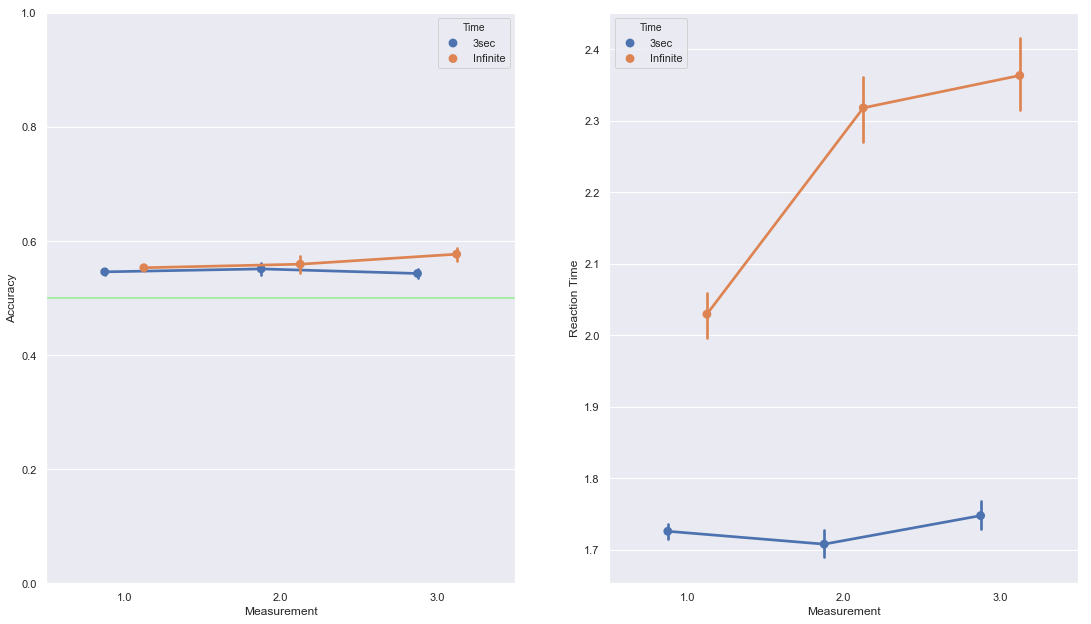

In [22]:
# create figure
fig, axes = plt.subplots(ncols=2)

# plot Measurements with Accuracy per Subject grouped by Time
axes[0] = sns.pointplot(x="Measurement", y="AccuracyCondTime", hue='Time', data=dfrelative, dodge=0.25, ax=axes[0])
# plot Measurement with the ReactionTime per Subject grouped by Time
axes[1] = sns.pointplot(x="Measurement", y="RTCondTime", hue='Time', data=dfrelative, dodge=0.25, ax=axes[1])
axes[0].set(xlabel='Measurement', ylabel='Accuracy')
axes[1].set(xlabel='Measurement', ylabel='Reaction Time')

# line at accuracy=0.5 for chance level
axes[0].axhline(0.5, color = 'lightgreen')
# limits for y-axis-values
axes[0].set(ylim=(0, 1))

# set plot size
fig.set_size_inches(18.5, 10.5)

plt.show()

Whether the Hypothesis __"With each subsequent session subjects get better in performance."__ holds
depends on the definition of __good performance__. We define it as high accuracy and/or low RT. 
According to this definition the hypothesis does not seem to hold: In the 3sec condition for both
***Reacion Time*** and ***Accuracy***, there is no clear increase or decrease from one session to another.
Therefore the ***3sec*** time condition data doesn't speak in favor of or against the hypothesis.
In the ***Infinite*** time condition the Accuracy is slightly increasing from session to session.
this would be the only bits speaking in favor of the hypothesis. The RT in the infinite time
condition is increasing steeply from session to session, speaking against the hypothesis.

### c) Hypothesis 4 [1 pts]

**Hypothesis 4:** "When the angular difference between houses increases subjects are more accurate in the relative task."

- Use the data of the relative task.
- For each angular difference (see "AngularDiffBin") calculate the accuracy per subject. Rename the column "Answer" to "Accuracy" (the accuracy corresponds to the averaged answer-values).
- Make a pointplot of the angular differences (x-axis) and the accuracy (y-axis) for both time conditions (3sec / Infinite). The y-axis should start at 0.0 and end at 1.0.
- For better comparison print both conditions in one plot and add a line at accuracy=0.5 to check if the results are above chance. Make sure that the angular differences are displayed in ascending order.
- Hint: Play with the keyword dodge.
- Considering your plots, what can you say about the hypothesis?

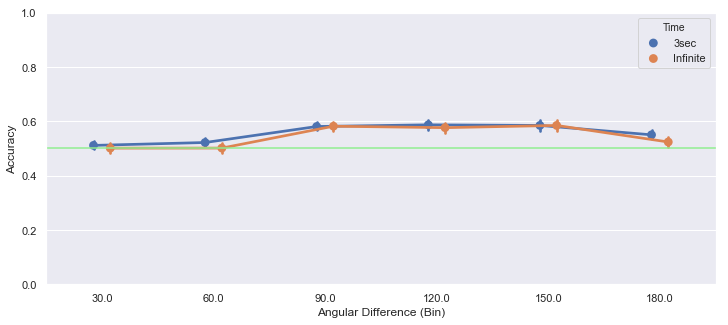

In [23]:
# create an extra column in order to compute the accuracy per subject grouped by angular difference 
dfrelative['AccuracyCondAngDiffBin'] = list(range(len(dfrelative.index)))
dfrelative['AccuracyCondAngDiffBin'] = dfrelative.groupby([dfrelative['Subject'], dfrelative['AngularDiffBin']])['Answer'].transform('mean')

#print(seaHaven)
fig, ax = plt.subplots(ncols=1)

# plot AngularDiffBin against respective group Accuracy
axes[0] = sns.pointplot(x="AngularDiffBin", y="AccuracyCondAngDiffBin", hue='Time', data=dfrelative, dodge=0.15)

axes[0].set(xlabel='Angular Difference (Bin)', ylabel='Accuracy')

# line at accuracy=0.5 for chance level
ax.axhline(0.5, color = 'lightgreen')
# limits for y-axis-values
ax.set(ylim=(0, 1))

# set plot size
fig.set_size_inches(12, 5)

We can see an increase of the accuracy for x-values between 90 and 150 where it levels for a while. But at 180 the Accuracy is deacreasing again. Therefore we can not say that the general relation, __"higher AngularDiffBin means higher accuracy"__, holds.


## Assignment 3: T-test [2 pts]

We will perform a two-sample t-test, i.e. we compare the mean of two groups under the assumption that both are independent and normally distributed with unknown but equal variances. In this case we will look at the data of the relative task and compare the accuracies of the two time conditions (3sec / Infinte). We will ignore that there are different measurement days!

- Use the data of the relative task.
- For each time condition (3sec / Infinite) calculate the accuracy per subject. Rename the column "Answer" to "Accuracy" (the accuracy corresponds to the averaged answer-values).
- Check if the data is normally distributed using scipy.stats.normaltest.


- Compute the t-statistics: $ t = \frac{\bar{x}_1 - \bar{x}_2}{\sqrt{\frac{s_1^2}{n_1} + \frac{s_2^2}{n_2}}} $

$\bar{x}_1$: mean accuracy of all subjects for time condition "3sec" <br>
$\bar{x}_2$: mean accuracy of all subjects for time condition "Infinite" <br>
$n_1$: sample size for time condition "3sec" <br>
$n_2$: sample size for time condition "Infinite"


- with $ s^2 = \frac{\sum_{i=1}^n{(x_i - \bar{x})^2}}{n-1} $

$x_i$: accuracy of subject i <br>
$\bar{x}$: mean accuracy of all subjects <br>
$n$: sample size


- Calculate the degrees of freedom: $ df = n_1 + n_2 -2 $
- What does the p-value of a t-test tell you in general? Also explain what your calculated p-value tells you specifically (given $\alpha = 0.05$)?

In [25]:
# Rename Answer column into Accuracy
dfrelative.rename(columns={'Answer': 'Accuracy'}, inplace=True)
# Compute the mean Accuracy grouped by Subject and Time 
df_relative_acc = dfrelative.groupby([dfrelative['Subject'],dfrelative['Time']],as_index=False)['Accuracy'].mean()

# respective dataframes to work according to Time conditions
dfrelative3sec = df_relative_acc[df_relative_acc['Time'] == '3sec']
dfrelativeinf = df_relative_acc[df_relative_acc['Time'] == 'Infinite']

# Series with the Accuracy values for respective time condition
normal3sec = dfrelative3sec['Accuracy']
normalInf = dfrelative3sec['Accuracy']

# Compute if we can assume a normal distribution
k_1, p_1 = stats.normaltest(normal3sec)
k_2, p_2 = stats.normaltest(normalInf)

print("We can assume a normal distribution for the 3 Seconds condition in the relative task if p > 0.05: ", p_1)
print("We can assume a normal distribution for the 3 Seconds condition in the relative task if p > 0.05: ", p_2)

# mean Accuracy for 3 Seconds condition of Time over all Subjects of only the relative task condition
x_1 = dfrelative3sec['Accuracy'].mean()
# mean Accuracy for Infinite condition of Time over all Subjects of only the relative task condition
x_2 = dfrelativeinf['Accuracy'].mean()

# Sample Size for the 3 Seconds condition of Time of only the relative task condition
n_1 = len(dfrelative3sec)
# Sample Size for the Infite condition of Time of only the relative task condition
n_2 = len(dfrelativeinf)


s_1 = (np.sum(dfrelative3sec['Accuracy'] - x_1)**2)/(n_1-1)
s_2 = (np.sum(dfrelativeinf['Accuracy'] - x_2)**2)/(n_2-1)

# final t calculation
t = (x_1 - x_2) / np.sqrt((((s_1)**2)/n_1) + (((s_2)**2)/n_2))

# Calculate the degrees of freedom
df = n_1 + n_2 - 2

# gives you the p-value after comparing the t-statistic with the critical t value (computed internally) 
p = 1 - stats.t.cdf(t,df=df)

print("t = " + str(t))
print("p = " + str(2*p))

# test if your calculation is correct
t2, p2 = stats.ttest_ind(normal3sec,x2)
print("t = " + str(t2))
print("p = " + str(p2))


alpha = 1e-3
if p < alpha:  # null hypothesis: x comes from a normal distribution
     print("The null hypothesis can be rejected")
else:
    print("The null hypothesis cannot be rejected")

We can assume a normal distribution for the 3 Seconds condition in the relative task if p > 0.05:  0.024362498319418047
We can assume a normal distribution for the 3 Seconds condition in the relative task if p > 0.05:  0.024362498319418047
t = -2.184131705391857e+29
p = 2.0
t = nan
p = nan
The null hypothesis cannot be rejected


C:\Users\kcob4\Anaconda3\envs\acc\lib\site-packages\numpy\core\fromnumeric.py:3367: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
C:\Users\kcob4\Anaconda3\envs\acc\lib\site-packages\numpy\core\_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\kcob4\Anaconda3\envs\acc\lib\site-packages\scipy\stats\_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\Users\kcob4\Anaconda3\envs\acc\lib\site-packages\scipy\stats\_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\Users\kcob4\Anaconda3\envs\acc\lib\site-packages\scipy\stats\_distn_infrastructure.py:1831: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


In general a small p value tells us that an impropable event has happened, if we believe our h0 hypothesis
assumptions are true. A p-value of alpha = 0.05 means that according to our assumptions, when we pick random
data and our assumption is true only in 5% of the experiments we pick data, such that our results come out.